In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.stats import skew
import seaborn as sns

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data and do some pre-processing

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print(f"train shape : {df_train.shape}")
print(f" test shape : {df_test.shape}")

train shape : (7160, 184)
 test shape : (1791, 183)


In [4]:
#資料格式
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Columns: 184 entries, ID to class
dtypes: bool(168), float64(6), int64(4), object(6)
memory usage: 2.0+ MB


In [5]:
#取得數值型態的欄位
numeric_data = df_train._get_numeric_data()
numeric_data.columns

Index(['appearedHour', 'appearedMinute', 'terrainType', 'closeToWater',
       'temperature', 'windSpeed', 'pressure', 'population_density', 'urban',
       'suburban',
       ...
       'cooc_143', 'cooc_144', 'cooc_145', 'cooc_146', 'cooc_147', 'cooc_148',
       'cooc_149', 'cooc_150', 'cooc_151', 'class'],
      dtype='object', length=178)

>## Drop NA in numeric data

In [6]:
# 檢查是否有NA，drop掉每個欄位的NA值並劃出其分布，只要有NaN，刪除該觀察值
for i in numeric_data:
    temp = df_train[i].dropna()
    print(f"there are {df_train[i].shape[0] - temp.shape[0]} NaN in {i}")

there are 0 NaN in appearedHour
there are 0 NaN in appearedMinute
there are 0 NaN in terrainType
there are 0 NaN in closeToWater
there are 0 NaN in temperature
there are 0 NaN in windSpeed
there are 0 NaN in pressure
there are 0 NaN in population_density
there are 0 NaN in urban
there are 0 NaN in suburban
there are 0 NaN in midurban
there are 0 NaN in rural
there are 0 NaN in gymDistanceKm
there are 0 NaN in gymIn100m
there are 0 NaN in gymIn250m
there are 0 NaN in gymIn500m
there are 0 NaN in gymIn1000m
there are 0 NaN in gymIn2500m
there are 0 NaN in gymIn5000m
there are 0 NaN in pokestopDistanceKm
there are 0 NaN in pokestopIn100m
there are 0 NaN in pokestopIn250m
there are 0 NaN in pokestopIn500m
there are 0 NaN in pokestopIn1000m
there are 0 NaN in pokestopIn2500m
there are 0 NaN in pokestopIn5000m
there are 0 NaN in cooc_1
there are 0 NaN in cooc_2
there are 0 NaN in cooc_3
there are 0 NaN in cooc_4
there are 0 NaN in cooc_5
there are 0 NaN in cooc_6
there are 0 NaN in cooc_7
th

In [7]:
# Drop Null Feature(s):  刪除不是 Feature 的欄位
df_all = pd.concat( [ df_train.drop( [ 'ID', 'class' ], axis = 1 ),
                      df_test.drop( [ 'id' ], axis = 1 ) ],
                      axis = 0, ignore_index = False )

In [8]:
# check null status
print( df_all.shape )
#exclude =  'object' 的目的是，Object type的情況下，NA很有可能只是代表沒有，而不是有遺失值，所以在做分析前一定要看資料描述
#isnull():  Detect missing values (NaN in numeric arrays, None/NaN in object arrays)
df_na = df_all.select_dtypes( exclude = [ 'object' ] ).isnull().sum()
if df_na.sum() == 0:
    print('There are no NA data in dataframe')

(8951, 182)
There are no NA data in dataframe


In [9]:
# handle skewness 處理解釋變數偏態問題
#.columns : 回傳columns名稱
num_feats = df_all.select_dtypes('float64').columns
# na drop should be done series by series:   drop NA 求偏態係數
skewed_feats = df_all[ num_feats ].apply( func = lambda s: skew(s.dropna()), axis = 0 )
# print每一個colume的偏態係數
print(skewed_feats)
# 大多人0.8才轉log，這裡0.75比較嚴謹
skewed_feats = skewed_feats[ skewed_feats > 0.75 ].index
# print(skewed_feats) 對偏態係數 > 0.75(右偏)取 log 1+X，使其比較偏常態
df_all[ skewed_feats ] = np.log1p( df_all[ skewed_feats ] )

temperature           -0.066715
windSpeed              1.002309
pressure              -0.101735
population_density     2.225346
gymDistanceKm         63.714548
pokestopDistanceKm    52.794770
dtype: float64


>## One-Hot Encoding

In [10]:
# check bool type data
df_all.select_dtypes('bool')

,closeToWater,urban,suburban,midurban,rural,gymIn100m,gymIn250m,gymIn500m,gymIn1000m,gymIn2500m,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,False,True,True,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
5,False,False,True,True,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
6,False,True,True,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
7,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
8,False,True,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,True,False,False,False,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df_all.select_dtypes('object')

,appearedTimeOfDay,city,continent,weather,weatherIcon
0,evening,Bangkok,Asia,Clear,clear-day
1,night,New_York,America,Clear,clear-night
2,evening,New_York,America,Clear,clear-day
3,morning,Hobart,Australia,Clear,clear-night
4,evening,Los_Angeles,America,PartlyCloudy,partly-cloudy-day
5,afternoon,Kuching,Asia,Clear,clear-day
6,night,Mexico_City,America,Clear,clear-night
7,afternoon,New_York,America,Clear,clear-day
8,night,Chicago,America,PartlyCloudy,partly-cloudy-day
9,afternoon,New_York,America,PartlyCloudy,partly-cloudy-day


In [12]:
column_name = df_all.select_dtypes('bool').columns
df_all[column_name] = df_all[column_name].astype( str )
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 1790
Columns: 182 entries, appearedTimeOfDay to cooc_151
dtypes: float64(6), int64(3), object(173)
memory usage: 12.5+ MB


In [13]:
df_all['appearedHour'] = df_all['appearedHour'] + (df_all['appearedMinute'] / 60)
df_all['terrainType'] = df_all['terrainType'].astype(str)

df_all.drop("midurban", axis = 1, inplace = True)
df_all.drop("rural", axis = 1, inplace = True)
df_all.drop("suburban", axis = 1, inplace = True)
df_all.drop("urban", axis = 1, inplace = True)
df_all.drop("appearedMinute", axis = 1, inplace = True)
df_all.drop("continent", axis = 1, inplace = True)
df_all.drop("gymIn100m", axis = 1, inplace = True)
df_all.drop("gymIn1000m", axis = 1, inplace = True)
df_all.drop("gymIn2500m", axis = 1, inplace = True)
df_all.drop("gymIn250m", axis = 1, inplace = True)
df_all.drop("gymIn5000m", axis = 1, inplace = True)
df_all.drop("gymIn500m", axis = 1, inplace = True)
df_all.drop("pokestopIn100m", axis = 1, inplace = True)
df_all.drop("pokestopIn1000m", axis = 1, inplace = True)
df_all.drop("pokestopIn2500m", axis = 1, inplace = True)
df_all.drop("pokestopIn250m", axis = 1, inplace = True)
df_all.drop("pokestopIn5000m", axis = 1, inplace = True)
df_all.drop("pokestopIn500m", axis = 1, inplace = True)


In [14]:
# one-hot-encoding
df_all_dum = pd.get_dummies(df_all); df_all_dum.head()

,appearedHour,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm,appearedTimeOfDay_afternoon,appearedTimeOfDay_evening,appearedTimeOfDay_morning,...,cooc_145_False,cooc_146_False,cooc_147_False,cooc_147_True,cooc_148_False,cooc_148_True,cooc_149_False,cooc_149_True,cooc_150_False,cooc_151_False
0,19.166667,27.8,2.302585,1008.96,8.702850,0.421180,0.134636,0,1,0,...,1,1,1,0,1,0,1,0,1,1
1,5.316667,26.1,2.272126,1018.96,0.000000,0.448056,0.181261,0,0,0,...,1,1,1,0,1,0,1,0,1,1
2,19.766667,24.7,2.880321,1023.22,0.000000,0.178452,0.068007,0,1,0,...,1,1,1,0,1,0,1,0,1,1
3,11.166667,12.7,2.656757,1014.19,4.866727,0.174053,0.003912,0,0,1,...,1,1,1,0,1,0,1,0,1,1
4,18.533333,19.1,1.913977,1011.36,8.340311,0.064026,0.069188,0,1,0,...,1,1,1,0,1,0,1,0,1,1


In [15]:
# 標準化
df_all_dum[ num_feats ] = preprocessing.scale( df_all_dum[ num_feats ] )
df_all_dum[ num_feats ].head()

,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
0,0.746395,0.546368,-1.019866,1.095041,-0.030837,-0.273872
1,0.465609,0.493535,0.695830,-1.862379,0.012945,-0.144405
2,0.234373,1.548480,1.426716,-1.862379,-0.426249,-0.458884
3,-1.747648,1.160696,-0.122557,-0.208558,-0.433415,-0.636860
4,-0.690571,-0.127692,-0.608099,0.971842,-0.612653,-0.455604


>## Check missing data 

In [16]:
total = df_all_dum.isnull().sum().sort_values(ascending=False)
percent = (df_all_dum.isnull().sum()/df_all_dum.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missingtype = missing_data.index
missingtype = missingtype.tolist()
missingtype = df_all_dum[missingtype].dtypes
missingtype = missingtype.rename(columns = 'missingtype')
missingtype = pd.DataFrame(missingtype)
missing_data = pd.concat([missing_data, missingtype], axis=1)
missing_data.columns = ['Total', 'Percent','Type']

missing_data.head(20)

,Total,Percent,Type
cooc_151_False,0,0.0,uint8
cooc_4_False,0,0.0,uint8
weatherIcon_fog,0,0.0,uint8
weatherIcon_partly-cloudy-day,0,0.0,uint8
weatherIcon_partly-cloudy-night,0,0.0,uint8
weatherIcon_rain,0,0.0,uint8
weatherIcon_wind,0,0.0,uint8
cooc_1_False,0,0.0,uint8
cooc_1_True,0,0.0,uint8
cooc_2_False,0,0.0,uint8


In [17]:
print(" One-Hot Encoding 後的 features 數量:",df_all_dum.shape)

 One-Hot Encoding 後的 features 數量: (8951, 412)


## Training Start

In [18]:
X = df_all_dum[:df_train.shape[0]]
pokemonclass = df_train['class']

label_ls = []
for label in tqdm_notebook(pokemonclass):
    onehot = np.zeros(6)  
    onehot[label] = 1
    label_ls.append(onehot)
        
y = np.array(label_ls)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, stratify = pokemonclass)

X_test = df_all_dum[ df_train.shape[0]: ]

In [19]:
print('size of training data:', X_train.shape, y_train.shape)
print('size of testing data:', X_val.shape, y_val.shape)

size of training data: (6444, 412) (6444, 6)
size of testing data: (716, 412) (716, 6)


In [20]:
epoch = 3000
bs = 100

initial_learning_rate = 0.001
# 指數衰減速率
decay_rate = 0.96
# decay_steps 越大遞減越緩慢
decay_steps = 300

In [21]:
tf.reset_default_graph()

with tf.name_scope('placeholder'):
    input_data = tf.placeholder(tf.float32, shape=[None, 412], name='X')
    y_true = tf.placeholder(tf.float32, shape=[None, 6], name='y')
    
with tf.variable_scope('network'):
    h1 = tf.layers.dense(input_data, 300, activation=tf.nn.relu, name='hidden1') 
    h2 = tf.layers.dense(h1, 200, activation=tf.nn.relu, name='hidden2') 
    h3 = tf.layers.dense(h2, 30, activation=tf.nn.relu, name='hidden3')
    out = tf.layers.dense(h3, 6, name='output')
    
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           epoch,
                                           decay_steps,decay_rate)
    
with tf.name_scope('opt'):
    update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    
saver = tf.train.Saver()
    
init = tf.global_variables_initializer()

In [22]:
pprint(tf.global_variables())

[<tf.Variable 'network/hidden1/kernel:0' shape=(412, 300) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias:0' shape=(300,) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/kernel:0' shape=(300, 200) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/bias:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'network/hidden3/kernel:0' shape=(200, 30) dtype=float32_ref>,
 <tf.Variable 'network/hidden3/bias:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'network/output/kernel:0' shape=(30, 6) dtype=float32_ref>,
 <tf.Variable 'network/output/bias:0' shape=(6,) dtype=float32_ref>,
 <tf.Variable 'opt/beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'opt/beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'network/hidden1/kernel/Adam:0' shape=(412, 300) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/kernel/Adam_1:0' shape=(412, 300) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias/Adam:0' shape=(300,) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias/Ad

In [23]:
train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

sess = tf.Session()
sess.run(init)

best_loss = 100.
patience = 300
count = 0

for i in tqdm_notebook(range(epoch)):
    
#     training part
    train_loss_batch, train_acc_batch = [], []
    
    total_batch = len(X_train) // bs
    
    for j in range(total_batch):
        
        X_batch = X_train[j*bs : (j+1)*bs]
        y_batch = y_train[j*bs : (j+1)*bs]
        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                            feed_dict={input_data: X_batch, y_true: y_batch})
        
        train_loss_batch.append(batch_loss)
        train_acc_batch.append(batch_acc)
        
    train_loss_epoch.append(np.mean(train_loss_batch))
    train_acc_epoch.append(np.mean(train_acc_batch))
    
#     testing part
    batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                     feed_dict={input_data: X_val, y_true: y_val})

    test_loss_epoch.append(batch_loss)
    test_acc_epoch.append(batch_acc)
    
    X_train, y_train = shuffle(X_train, y_train)
    
    if i%5 == 0:
        print('step: {:2d}, train loss: {:.3f}, train acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}'
             .format(i, train_loss_epoch[i], train_acc_epoch[i], test_loss_epoch[i], test_acc_epoch[i]))
    
# Early stopping        
    if batch_loss < best_loss:
        best_loss = batch_loss
        # 如果是 best loss 就把模型儲存起來
        saver.save(sess, './cd_class/bestweight.ckpt', global_step=i)
        count = 0  
    else:
        count += 1
    
    if count >= patience:
        print("The model didn't improve for {} rounds, break it!".format(patience))
        break

step:  0, train loss: 1.606, train acc: 0.345, test loss: 1.417, test acc: 0.453
step:  5, train loss: 1.165, train acc: 0.566, test loss: 1.207, test acc: 0.542
step: 10, train loss: 1.087, train acc: 0.592, test loss: 1.245, test acc: 0.534
step: 15, train loss: 1.057, train acc: 0.597, test loss: 1.148, test acc: 0.589
step: 20, train loss: 0.987, train acc: 0.631, test loss: 1.190, test acc: 0.552
step: 25, train loss: 0.945, train acc: 0.648, test loss: 1.234, test acc: 0.550
step: 30, train loss: 0.899, train acc: 0.665, test loss: 1.202, test acc: 0.561
step: 35, train loss: 0.856, train acc: 0.677, test loss: 1.215, test acc: 0.571
step: 40, train loss: 0.803, train acc: 0.696, test loss: 1.222, test acc: 0.566
step: 45, train loss: 0.738, train acc: 0.720, test loss: 1.281, test acc: 0.567
step: 50, train loss: 0.695, train acc: 0.733, test loss: 1.319, test acc: 0.577
step: 55, train loss: 0.649, train acc: 0.755, test loss: 1.398, test acc: 0.536
step: 60, train loss: 0.607,

In [24]:
#  tf.train.latest_checkpoint 會自動把路徑夏最新一次的結果取出，也可以寫出完整路徑，
#saver.restore(sess, './cd_class/bestweight.ckpt-XX')
saver.restore(sess, tf.train.latest_checkpoint('./cd_class'))  
print(sess.run(loss, feed_dict={input_data: X_val, y_true: y_val}))

INFO:tensorflow:Restoring parameters from ./cd_class/bestweight.ckpt-15
1.1479251


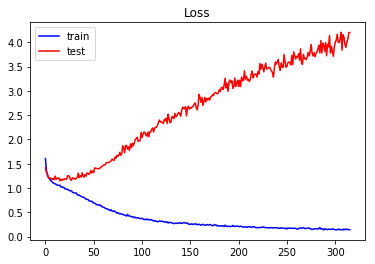

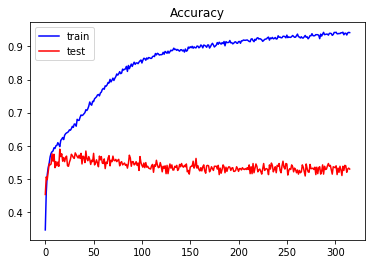

In [25]:
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(test_loss_epoch, 'r', label='test')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(test_acc_epoch, 'r', label='test')
plt.legend()
plt.title("Accuracy")
plt.show()

### 看起來有 overfiting 的現象，這種結構式的資料還是比較適合用 machine learning 的方法去做分類

In [26]:
predict = sess.run(tf.argmax(tf.nn.softmax(out), 1), feed_dict={input_data: X_test})
print('predict: ', predict )

predict:  [2 2 2 ... 1 2 1]


In [27]:
sess.close()

In [28]:
predict = pd.DataFrame(predict)

In [29]:
result = pd.concat([df_test['id'], predict[0]], axis=1)

In [30]:
result.columns = ['ID', 'class']

blankIndex=[''] * len(result)
result.index=blankIndex
result

,ID,class
,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,2
,MTY0OTUyMTM2MDExMjg3MjczMjU=,2
,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,2
,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,3
,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,5
,MTkwNTk1MzkyNzkwNjQ3MDUyNQ==,2
,MTU4NzAwMDQyODIwMTM2MDEyMjk=,1
,ODY5MDY1ODA4Njk5MjAwODI5,3
,MjA2MzcwMzk1Mzg2MTQ0NDMwMQ==,2
,NjcwNDcxODcwMTUxODQxNDE=,3


In [31]:
result.to_csv('submission.csv',index=False)